In [ ]:
!pip install fuzzywuzzy

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import random

from fuzzywuzzy import process, fuzz

In [ ]:
anime = pd.read_csv('anime.csv')
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
rating = pd.read_csv('rating.csv')
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [ ]:
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Заполняем пропуски

In [ ]:
anime.type.fillna("NULL",inplace=True)
anime.rating.fillna(anime.rating.mean(),inplace=True)
anime.genre.fillna("",inplace=True)

In [ ]:
anime.genre.unique()

array(['Drama, Romance, School, Supernatural',
       'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen',
       'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen',
       ..., 'Hentai, Sports', 'Drama, Romance, School, Yuri',
       'Hentai, Slice of Life'], dtype=object)

In [ ]:
animeCOPY = anime.copy()

In [ ]:
# удаляем лишние пробелы
animeCOPY.genre = animeCOPY.genre.apply(lambda x: ' '.join(x.split(' ')).split(', '))

# список всех жанров
genres = [] 
# то есть создаем dummy переменные по жанрам
for i in range(len(animeCOPY)):
    for g in animeCOPY.genre[i]:
        if g in genres:
            animeCOPY["genre_"+g][i] = 1
        else:
            animeCOPY["genre_"+g] = 0
            animeCOPY["genre_"+g][i] = 1
            genres.append(g)

# создаем dummy переменные у переменной type (movie, TV etc.)
animeCOPY = pd.concat([animeCOPY,pd.get_dummies(animeCOPY['type'], prefix='type',dummy_na=True)],axis=1).drop(['type'],axis=1)
animeCOPY.drop(["genre"],axis=1,inplace=True)

#удаляем информацию об эпизодах, так как много случаев, где они неизвестны
animeCOPY.drop(["episodes"],axis=1,inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
animeCOPY.head()

,anime_id,name,rating,members,genre_Drama,genre_Romance,genre_School,genre_Supernatural,genre_Action,genre_Adventure,genre_Fantasy,genre_Magic,genre_Military,genre_Shounen,genre_Comedy,genre_Historical,genre_Parody,genre_Samurai,genre_Sci-Fi,genre_Thriller,genre_Sports,genre_Super Power,genre_Space,genre_Slice of Life,genre_Mecha,genre_Music,genre_Mystery,genre_Seinen,genre_Martial Arts,genre_Vampire,genre_Shoujo,genre_Horror,genre_Police,genre_Psychological,genre_Demons,genre_Ecchi,genre_Josei,genre_Shounen Ai,genre_Game,genre_Dementia,genre_Harem,genre_Cars,genre_Kids,genre_Shoujo Ai,genre_,genre_Hentai,genre_Yaoi,genre_Yuri,type_Movie,type_Music,type_NULL,type_ONA,type_OVA,type_Special,type_TV,type_nan
0,32281,Kimi no Na wa.,9.37,200630,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,9.26,793665,1,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,28977,Gintama°,9.25,114262,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,9253,Steins;Gate,9.17,673572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,9969,Gintama&#039;,9.16,151266,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Посмотрим, сколько фильмов, относящихся к конкретному жанру: 

In [ ]:
sum_eachGenre = []
sum_eachGenre = animeCOPY.iloc[:, 5:len(genres) + 5].sum(axis=0)

In [ ]:
dict_genres = dict(zip(genres, sum_eachGenre))
dict_genres = dict(sorted(dict_genres.items(), key=lambda x: x[1], reverse=True))

<BarContainer object of 44 artists>

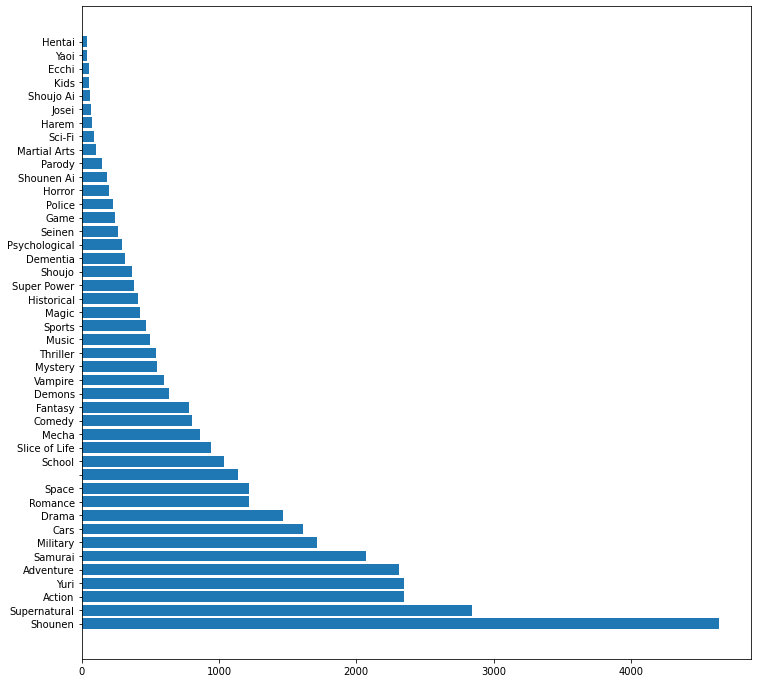

In [ ]:
fig = plt.figure(figsize=(12,12))
plt.barh(list(dict_genres.keys()), dict_genres.values())

Таким образом, **самым популярным** жанром является комедия, а за ним идут Action, Adventure, Fantasy, Sci-Fi, Drama и Shounen. 

**Самые непопулярные жанры**: Yuri, Yaoi, Josei, Shoujo Ai,Shounen Ai, Cars.

Связь между жанрами

In [ ]:
import seaborn as sns; sns.set(style = 'white', palette = 'muted')

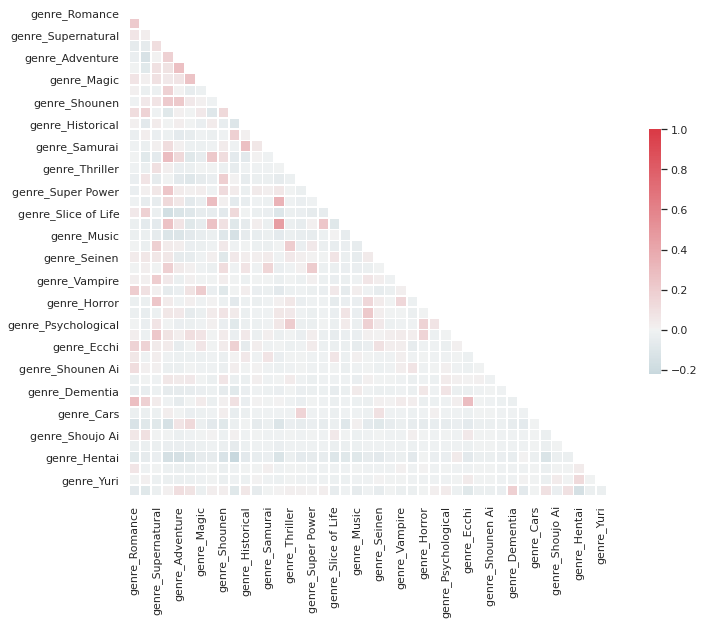

In [ ]:
corr = animeCOPY.iloc[:, 5:len(genres) + 5].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Посмотрим на названия аниме, как они связаны между собой. 

Нужно попробовать использовать что-то другое, так как работает настолько долго, что ни разу не дождались.

In [ ]:
#Create tuples of brand names, matched brand names, and the score
score_sort = [(x,) + i
             for x in (animeCOPY.name.tolist())
             for i in process.extract(x, animeCOPY.name,     scorer=fuzz.token_sort_ratio)]
#Create a dataframe from the tuples
similarity_sort = pd.DataFrame(score_sort, columns=['name_1','name_2','score_sort'])
similarity_sort.head()

KeyboardInterrupt: ignored

# **КЛАСТЕРИЗАЦИЯ**

Делим данные  на группы, но при этом ответов, какие группы правильные, у нас нет

Алгоритм k-means


1. Возьмем случайным образом k точек и назовем их центрами кластеров.
2. Для каждой точки найдем ближайший центр и будем считать, что точка пренадлежит этому кластеру.
3. Вычислим новые знацения центров, как среднее арифметическое координат точек приписанных этому кластеру на предыдущем шаге.
4. Будем повторять шаги 2-3 пока центры не перестанут меняться.

In [ ]:
animeCOPY.head()

,anime_id,name,rating,members,genre_Drama,genre_Romance,genre_School,genre_Supernatural,genre_Action,genre_Adventure,genre_Fantasy,genre_Magic,genre_Military,genre_Shounen,genre_Comedy,genre_Historical,genre_Parody,genre_Samurai,genre_Sci-Fi,genre_Thriller,genre_Sports,genre_Super Power,genre_Space,genre_Slice of Life,genre_Mecha,genre_Music,genre_Mystery,genre_Seinen,genre_Martial Arts,genre_Vampire,genre_Shoujo,genre_Horror,genre_Police,genre_Psychological,genre_Demons,genre_Ecchi,genre_Josei,genre_Shounen Ai,genre_Game,genre_Dementia,genre_Harem,genre_Cars,genre_Kids,genre_Shoujo Ai,genre_,genre_Hentai,genre_Yaoi,genre_Yuri,type_Movie,type_Music,type_NULL,type_ONA,type_OVA,type_Special,type_TV,type_nan
0,32281,Kimi no Na wa.,9.37,200630,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,5114,Fullmetal Alchemist: Brotherhood,9.26,793665,1,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,28977,Gintama°,9.25,114262,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,9253,Steins;Gate,9.17,673572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,9969,Gintama&#039;,9.16,151266,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
animeklaster=animeCOPY.drop(columns=['anime_id','name'])

In [ ]:
animeklaster.head()

,rating,members,genre_Drama,genre_Romance,genre_School,genre_Supernatural,genre_Action,genre_Adventure,genre_Fantasy,genre_Magic,genre_Military,genre_Shounen,genre_Comedy,genre_Historical,genre_Parody,genre_Samurai,genre_Sci-Fi,genre_Thriller,genre_Sports,genre_Super Power,genre_Space,genre_Slice of Life,genre_Mecha,genre_Music,genre_Mystery,genre_Seinen,genre_Martial Arts,genre_Vampire,genre_Shoujo,genre_Horror,genre_Police,genre_Psychological,genre_Demons,genre_Ecchi,genre_Josei,genre_Shounen Ai,genre_Game,genre_Dementia,genre_Harem,genre_Cars,genre_Kids,genre_Shoujo Ai,genre_,genre_Hentai,genre_Yaoi,genre_Yuri,type_Movie,type_Music,type_NULL,type_ONA,type_OVA,type_Special,type_TV,type_nan
0,9.37,200630,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,9.26,793665,1,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,9.25,114262,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,9.17,673572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,9.16,151266,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#Нормализация
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_animeklaster = scaler.fit_transform(animeklaster)
scaled_animeklaster[0:5]

array([[ 2.84753513,  3.33024137,  2.25792256,  2.71984209,  3.01281416,
         3.29474612, -0.54871674, -0.4858753 , -0.48088135, -0.25991956,
        -0.18945934, -0.40208753, -0.77927461, -0.26487765, -0.18527304,
        -0.11038606, -0.44996087, -0.08442191, -0.2149624 , -0.19826792,
        -0.17883475, -0.33191559, -0.28839523, -0.27425221, -0.2048236 ,
        -0.21578944, -0.14842538, -0.09146662, -0.22710821, -0.17590735,
        -0.12761281, -0.13776982, -0.15652476, -0.23376329, -0.06642112,
        -0.07290565, -0.12224002, -0.14110423, -0.16268803, -0.07675296,
        -0.38805274, -0.06703604, -0.07119461, -0.31985045, -0.05641254,
        -0.05854923,  2.05814127, -0.2033099 , -0.0451404 , -0.23799044,
        -0.6071121 , -0.39729733, -0.66720522,  0.        ],
       [ 2.73937967, 14.14840622,  2.25792256, -0.3676684 , -0.33191559,
        -0.30351352,  1.82243392,  2.05814127,  2.07951505,  3.84734409,
         5.27817724,  2.48702066, -0.77927461, -0.26487765, -0.

In [ ]:
kmodel_scaled = KMeans(n_clusters=5, random_state=456)
kmodel_scaled.fit(scaled_animeklaster)
# Предсказание на всем наборе данных
all_predictions_scaled = kmodel_scaled.predict(scaled_animeklaster)
all_predictions_scaled

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [ ]:
#центры кластеров 
kmodel_scaled.cluster_centers_

array([[ 7.92521890e-01,  9.86154029e-01,  3.56583431e-01,
         1.06831789e+00,  8.15845252e-01,  6.94734392e-01,
         6.39559125e-02, -1.88342987e-01,  7.27492429e-02,
         3.82422213e-01, -4.07475610e-02,  6.15318245e-02,
         3.47350837e-01, -2.49560937e-02, -1.82471857e-02,
        -1.06272039e-02, -1.34993583e-01,  3.10350203e-01,
        -7.37638140e-02,  9.40075133e-02, -1.42212700e-01,
         3.47340495e-01, -1.91349005e-01, -1.39184050e-01,
         3.69374626e-01,  4.37171204e-01, -1.48425382e-01,
         3.43313217e-01,  6.14572917e-01,  2.04003205e-01,
        -3.37509634e-02,  2.71270511e-01,  2.14355251e-01,
         4.77947955e-01,  2.69468201e-01,  2.95891501e-01,
        -2.43821222e-02, -1.14891847e-01,  5.80942808e-01,
        -5.29894612e-02, -3.61171311e-01,  2.86176999e-01,
        -7.11946089e-02, -3.19850454e-01, -5.64125389e-02,
        -5.07803245e-02, -2.92133328e-01, -2.03309898e-01,
        -1.49524000e-02, -1.65536118e-01, -3.18943594e-0

In [ ]:
#Подробное описание кластеров
res = animeklaster.copy()
res["cluster"] = kmodel_scaled.labels_
res.groupby("cluster").mean()

,rating,members,genre_Drama,genre_Romance,genre_School,genre_Supernatural,genre_Action,genre_Adventure,genre_Fantasy,genre_Magic,genre_Military,genre_Shounen,genre_Comedy,genre_Historical,genre_Parody,genre_Samurai,genre_Sci-Fi,genre_Thriller,genre_Sports,genre_Super Power,genre_Space,genre_Slice of Life,genre_Mecha,genre_Music,genre_Mystery,genre_Seinen,genre_Martial Arts,genre_Vampire,genre_Shoujo,genre_Horror,genre_Police,genre_Psychological,genre_Demons,genre_Ecchi,genre_Josei,genre_Shounen Ai,genre_Game,genre_Dementia,genre_Harem,genre_Cars,genre_Kids,genre_Shoujo Ai,genre_,genre_Hentai,genre_Yaoi,genre_Yuri,type_Movie,type_Music,type_NULL,type_ONA,type_OVA,type_Special,type_TV,type_nan
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7.280862,72250.920945,0.295320,0.464334,0.343935,0.277601,0.256701,0.116311,0.215811,0.156747,0.026806,0.160382,0.546570,0.059064,0.029986,0.010904,0.117219,0.032712,0.029078,0.055429,0.006361,0.203544,0.025443,0.034530,0.113130,0.134939,0.0,0.039527,0.182190,0.064970,0.011813,0.055429,0.056792,0.158110,0.022263,0.026806,0.011813,0.003635,0.118128,0.001817,0.009087,0.023626,0.000000,0.000000,0.0000,0.000454,0.075875,0.0,0.001363,0.015902,0.128124,0.106770,0.671967,0.0
1,6.818052,26814.222642,0.128302,0.113208,0.143396,0.083019,0.769811,0.301887,0.215094,0.041509,0.003774,0.396226,0.358491,0.192453,0.022642,0.124528,0.090566,0.000000,0.064151,0.305660,0.011321,0.056604,0.022642,0.003774,0.011321,0.049057,1.0,0.000000,0.018868,0.030189,0.011321,0.003774,0.056604,0.086792,0.000000,0.000000,0.011321,0.003774,0.030189,0.000000,0.011321,0.000000,0.000000,0.026415,0.0000,0.003774,0.181132,0.0,0.000000,0.049057,0.305660,0.105660,0.358491,0.0
2,5.588996,1311.840164,0.053279,0.038934,0.018443,0.024590,0.034836,0.018443,0.084016,0.020492,0.002049,0.000000,0.036885,0.004098,0.000000,0.002049,0.055328,0.000000,0.004098,0.008197,0.014344,0.045082,0.012295,0.997951,0.002049,0.004098,0.0,0.008197,0.014344,0.012295,0.002049,0.008197,0.002049,0.004098,0.000000,0.000000,0.000000,0.036885,0.002049,0.002049,0.200820,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,6.310901,4212.690964,0.154854,0.069197,0.051394,0.054081,0.187101,0.125294,0.150487,0.047363,0.034263,0.084313,0.218005,0.043332,0.028216,0.007726,0.163252,0.001344,0.029560,0.023514,0.031575,0.039301,0.079610,0.019483,0.025193,0.034599,0.0,0.001344,0.024857,0.037286,0.018139,0.011421,0.030232,0.039973,0.001008,0.002015,0.005039,0.004703,0.014780,0.003695,0.123950,0.000672,0.000336,0.380584,0.0131,0.012765,0.002687,0.0,0.000336,0.000672,0.988915,0.007390,0.000000,0.0
4,6.324564,6735.444759,0.132799,0.029389,0.041333,0.036304,0.236052,0.256168,0.202420,0.042590,0.041333,0.157473,0.421185,0.077636,0.039604,0.010530,0.200377,0.001729,0.058463,0.029546,0.041333,0.097124,0.100424,0.037404,0.026245,0.020745,0.0,0.001100,0.018230,0.015873,0.017759,0.010687,0.009901,0.022788,0.000314,0.000000,0.021531,0.031275,0.000629,0.008801,0.175860,0.000157,0.009587,0.000157,0.0000,0.000314,0.333962,0.0,0.003300,0.095710,0.000629,0.218608,0.347792,0.0


# Продолжение кластеризации


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


plt.rcParams['figure.figsize'] = (6, 4)
plt.style.use('ggplot')
%config InlineBackend.figure_formats = {'png', 'retina'}

In [ ]:
anime = pd.read_csv('anime.csv')

In [ ]:
user = pd.read_csv('rating.csv')

Немного сократили данные, чтобы быстрее считалось


In [ ]:
# merge 2 dataset
mergedata = pd.merge(anime,user,on=['anime_id','anime_id'])
mergedata= mergedata[mergedata.user_id <= 70000]
mergedata.head(10)

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,278,-1
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,322,10
6,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,398,10
7,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,462,8
8,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,490,10
9,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,548,10


In [ ]:
len(mergedata['anime_id'].unique())

4995

In [ ]:
len(anime['anime_id'].unique())

12294

In [ ]:
user_anime = pd.crosstab(mergedata['user_id'], mergedata['name'])
user_anime.head(10)

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,.hack//Quantum: Sore ike! Bokura no Chimuchimu-chan!!,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,.hack//Tasogare no Udewa Densetsu: Offline de Aimashou,.hack//The Movie: Sekai no Mukou ni,.hack//Unison,.hack//Versus: The Thanatos Report,009 Re:Cyborg,009-1,07-Ghost,1+2=Paradise,11eyes,11eyes Picture Drama,11eyes: Momoiro Genmutan,12-sai.,12-sai.: Chicchana Mune no Tokimeki,15 Bishoujo Hyouryuuki,20-dai no Heya-hen,3 Choume no Tama: Uchi no Tama Shirimasenka?,3-gatsu no Lion meets Bump of Chicken,30-sai no Hoken Taiiku,30-sai no Hoken Taiiku Specials,30th Gundam Perfect Mission,3Ping Lovers!☆Ippu Nisai no Sekai e Youkoso♪ The Animation,3x3 Eyes,3x3 Eyes Seima Densetsu,6♥Princess,91 Days,91 Days Recap,...,Zetsumetsu Kigu Shoujo: Amazing Twins,Zettai Bouei Leviathan,Zettai Bouei Leviathan: Mini Takibi Gekijou,Zettai Junpaku♡Mahou Shoujo,Zettai Junshu☆Kyousei Kozukuri Kyokashou!!,Zettai Karen Children,Zettai Karen Children OVA: Aitazousei! Ubawareta Mirai?,Zettai Karen Children: The Unlimited - Hyoubu Kyousuke,Zettai Shougeki: Platonic Heart,Zettai Shounen,Zoids,Zoids Genesis,Zoids Shinseiki/Zero,Zoku Natsume Yuujinchou,Zoku Natsume Yuujinchou: 3D Nyanko-sensei Gekijou,Zoku Sayonara Zetsubou Sensei,Zombie-Loan,Zombie-Loan Specials,"Zone of the Enders: Dolores, I",Zone of the Enders: Idolo,Zonmi-chan: Meat Pie of the Dead,Zutto Mae kara Suki deshita.: Kokuhaku Jikkou Iinkai,_Summer,eX-Driver,eX-Driver the Movie,ef: A Tale of Melodies.,ef: A Tale of Melodies. - Prologue,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,ef: A Tale of Memories. - Recollections,gdgd Fairies,gdgd Fairies 2,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
user_anime.shape

(869, 4995)

## Principal component analysis

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(user_anime)
pca_samples = pca.transform(user_anime)

In [ ]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2
0,3.048853,4.269250,-0.111988
1,-2.747888,0.576706,0.626330
2,0.332052,-1.123537,0.928023
3,-0.908948,0.371474,-0.520959
4,9.417192,2.753583,-0.615731


In [ ]:
tocluster = pd.DataFrame(ps[[0,1,2]])

In [ ]:
plt.rcParams['figure.figsize'] = (16, 9)


fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1])

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()


## Selecting number of k

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
inertia_list = np.empty(8)

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(tocluster)
    inertia_list[i] = kmeans.inertia_
    scores.append(silhouette_score(tocluster, kmeans.labels_))
    


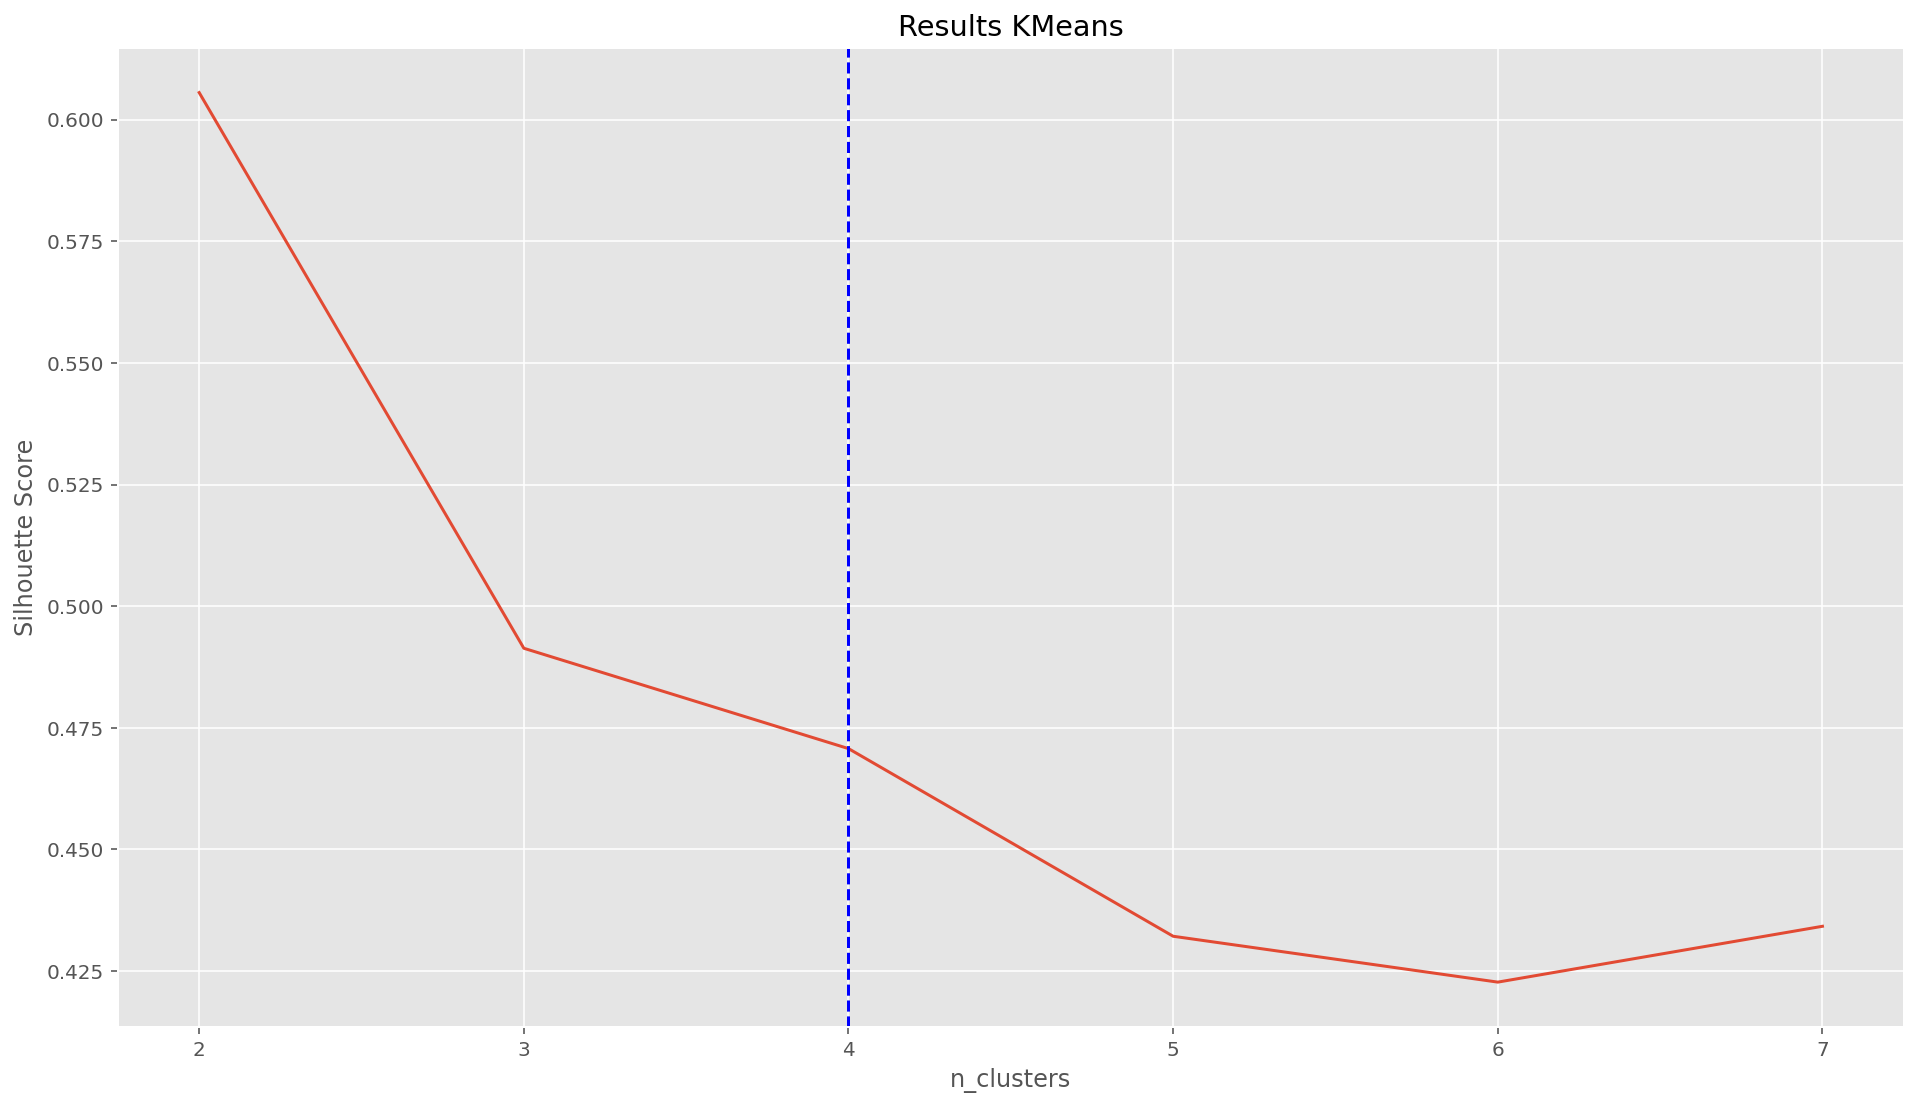

In [ ]:
plt.plot(range(2,8), scores);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=4, color='blue', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

## K means clustering

In [ ]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=4,random_state=30).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)

print(centers)

[[-1.9615207   0.20954211  0.14048889]
 [ 2.93713351  1.27602254 -1.01934217]
 [ 8.62258953  0.63388757  1.05866452]
 [ 0.97413245 -1.89106201 -0.15993843]]


In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1], c = c_preds)
plt.title('Data points in 3D PCA axis', fontsize=20)

plt.show()

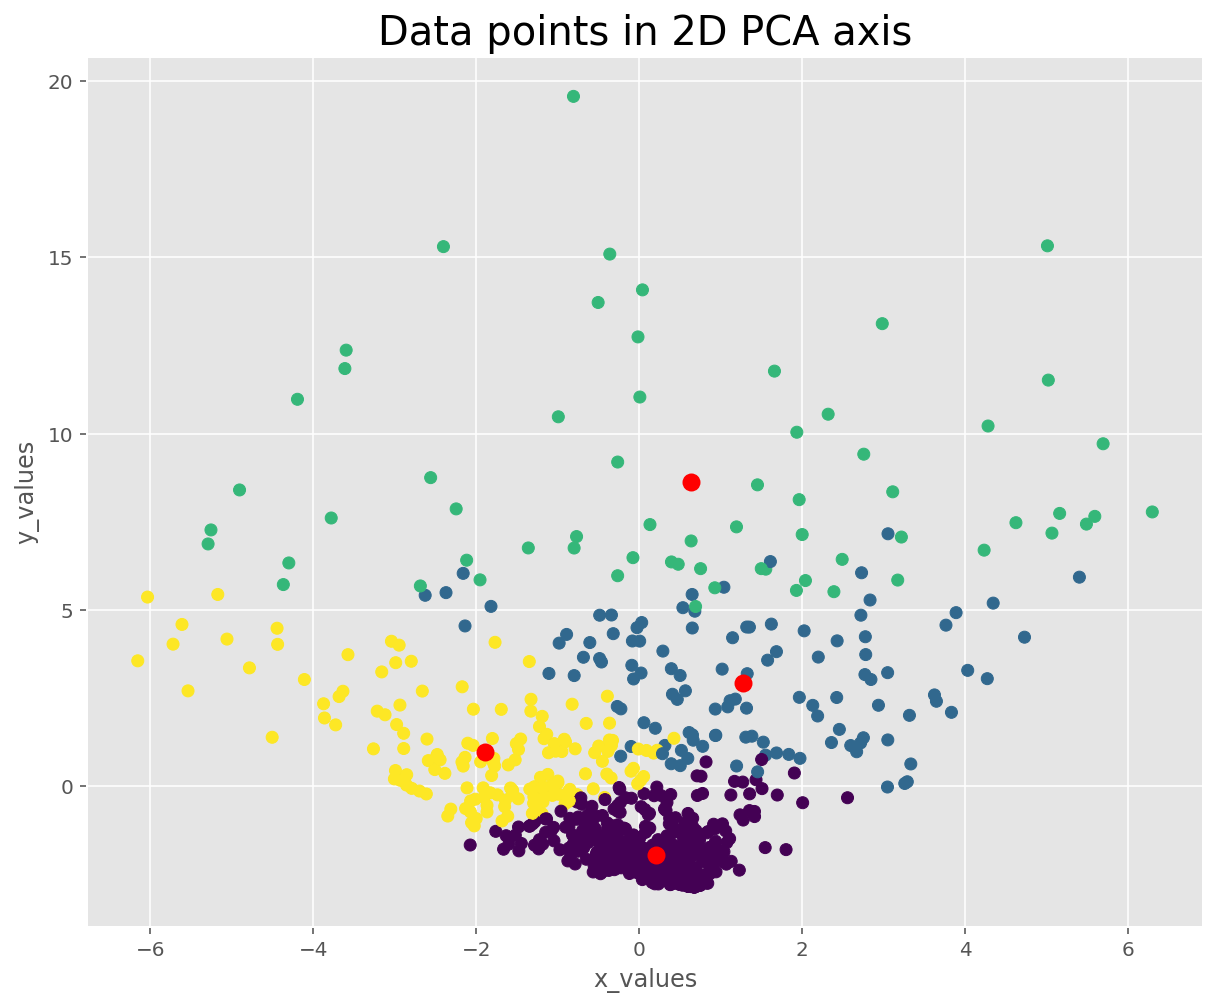

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.scatter(tocluster[1],tocluster[0],c = c_preds)
for ci,c in enumerate(centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points in 2D PCA axis', fontsize=20)
plt.show()

Кластеры различимы, но находятся достаточно близко к друг другу и определенно имеют много пересечений


In [ ]:
user_anime['cluster'] = c_preds


user_anime.head(10)

In [ ]:
user_anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869 entries, 1 to 869
Columns: 4996 entries, &quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi to cluster
dtypes: int32(1), int64(4995)
memory usage: 33.1 MB


## Посмотрим на каждый кластер

In [ ]:

c0 = user_anime[user_anime['cluster']==0].drop('cluster',axis=1).mean()
c1 = user_anime[user_anime['cluster']==1].drop('cluster',axis=1).mean()
c2 = user_anime[user_anime['cluster']==2].drop('cluster',axis=1).mean()
c3 = user_anime[user_anime['cluster']==3].drop('cluster',axis=1).mean()


### Cluster 0

Топ 15 аниме, относящихся к первому кластеру


In [ ]:
c0.sort_values(ascending=False)[0:15]

name
Death Note                          0.430451
Sword Art Online                    0.385338
Shingeki no Kyojin                  0.330827
Angel Beats!                        0.261278
Fullmetal Alchemist: Brotherhood    0.248120
Naruto                              0.244361
Elfen Lied                          0.240602
Mirai Nikki (TV)                    0.233083
Ao no Exorcist                      0.203008
Highschool of the Dead              0.203008
Another                             0.199248
Fullmetal Alchemist                 0.189850
Code Geass: Hangyaku no Lelouch     0.184211
Sen to Chihiro no Kamikakushi       0.182331
Ouran Koukou Host Club              0.167293
dtype: float64

In [ ]:
def createAnimeInfoList(animelist):
    episode_list = list()
    genre_list = list()
    member_list = list()
    rating_list= list()
    for x in anime['name']:
        if x in animelist:
            episode_list.append(anime[anime['name']==x].episodes.values.astype(int))
            member_list.append(anime[anime['name']==x].members.values.astype(int))
            rating_list.append(anime[anime['name']==x].rating.values.astype(int))
            for y in anime[anime['name']==x].genre.values:
                 genre_list.append(y)
    return genre_list,episode_list,rating_list,member_list
         

Сети- графы считались долго, поэтому возьмем схожесть жанров по частоте встречаемости слов вместе


In [ ]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split(','):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [ ]:
animelist = list(c0.index)
data = pd.DataFrame()
data['genre'],data['episode'],data['rating'],data['member'] =  createAnimeInfoList(animelist)


In [ ]:

set_keywords = set()
for liste_keywords in data['genre'].str.split(',').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)


In [ ]:
from wordcloud import WordCloud

def makeCloud(Dict,name,color):
    words = dict()

    for s in Dict:
        words[s[0]] = s[1]

        wordcloud = WordCloud(
                      width=1500,
                      height=500, 
                      background_color=color, 
                      max_words=20,
                      max_font_size=500, 
                      normalize_plurals=False)
        wordcloud.generate_from_frequencies(words)


    fig = plt.figure(figsize=(12, 8))
    plt.title(name)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

Наиболее часто представленный жанр получился action, поэтому для сравнения кластеров интересней смотреть на более низкочастотные слова 

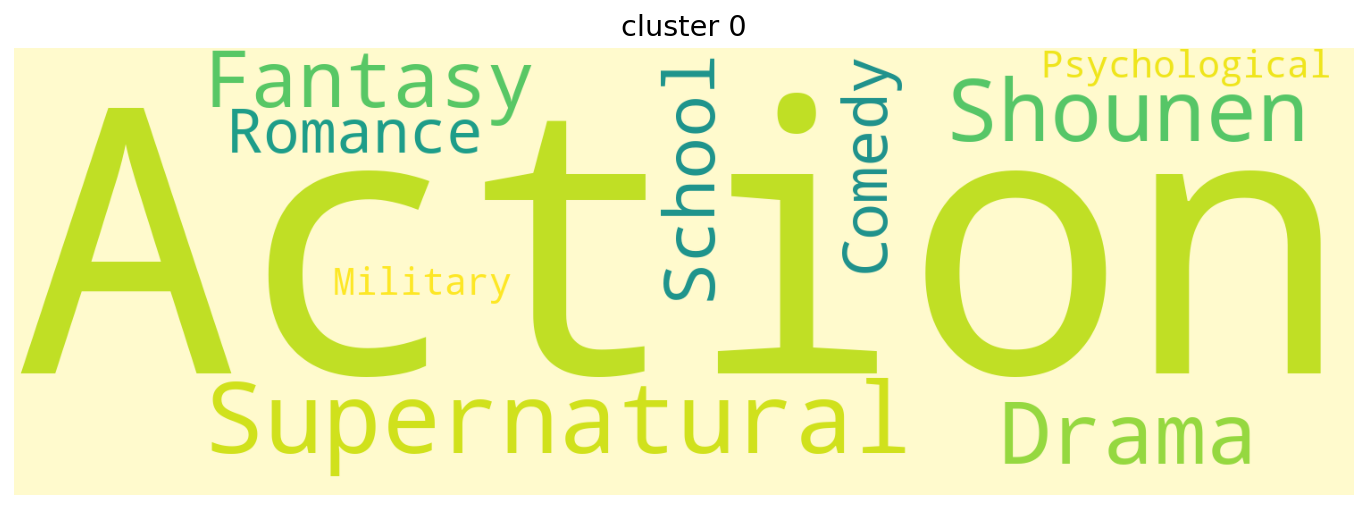

In [ ]:
c0_animelist = list(c0.sort_values(ascending=False)[0:15].index)
c0_data = pd.DataFrame()
c0_data['genre'],c0_data['episode'],c0_data['rating'],c0_data['member'] =  createAnimeInfoList(c0_animelist)
c0_data.iloc[:,1:4] = c0_data.iloc[:,1:4].astype(int) # change to numeric object to integer
keyword_occurences, dum = count_word(c0_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 0","lemonchiffon")

In [ ]:
keyword_occurences[0:5]

[['Action', 11],
 [' Supernatural', 8],
 [' Drama', 6],
 [' Shounen', 6],
 [' Fantasy', 5]]

In [ ]:
print('cluster 0\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c0_data['episode'].mean(), c0_data['rating'].mean(),c0_data['member'].mean()))

cluster 0
AVG episode : 38.333333333333336
AVG movie rating : 7.666666666666667
AVG member : 675809.1333333333


### Cluster 1

In [ ]:
c1.sort_values(ascending=False)[0:15]

name
Sword Art Online                                       0.895652
Shingeki no Kyojin                                     0.808696
High School DxD                                        0.773913
Angel Beats!                                           0.756522
Highschool of the Dead                                 0.739130
Hataraku Maou-sama!                                    0.704348
Boku wa Tomodachi ga Sukunai                           0.686957
Date A Live                                            0.660870
Mirai Nikki (TV)                                       0.660870
Yahari Ore no Seishun Love Comedy wa Machigatteiru.    0.660870
Guilty Crown                                           0.652174
Toradora!                                              0.652174
IS: Infinite Stratos                                   0.652174
No Game No Life                                        0.643478
Zero no Tsukaima                                       0.643478
dtype: float64

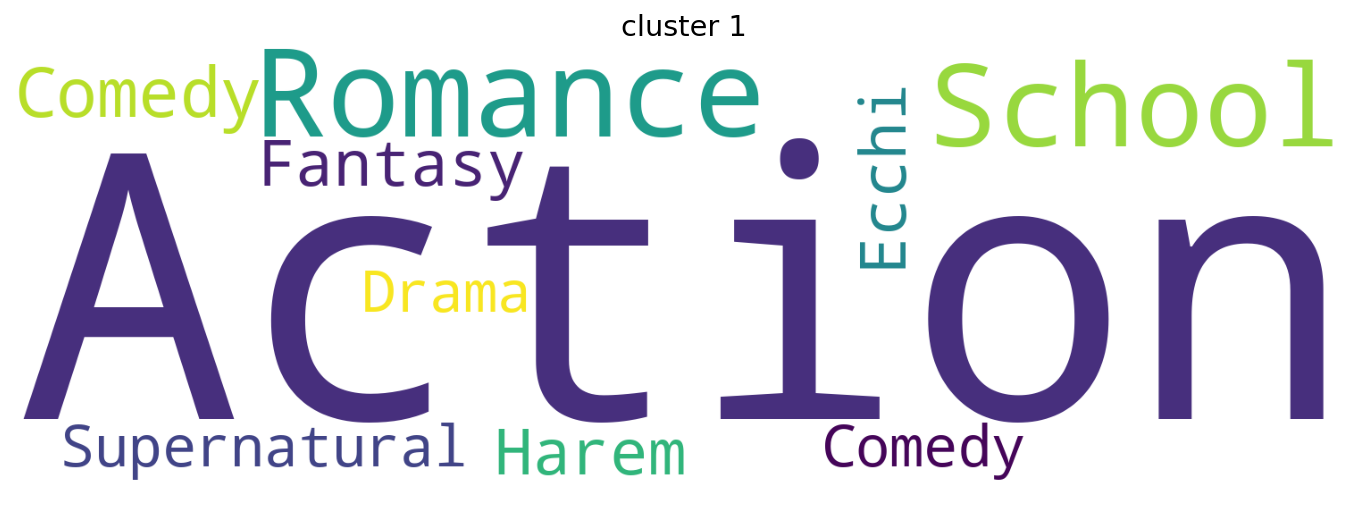

In [ ]:
c1_animelist = list(c1.sort_values(ascending=False)[0:15].index)
c1_data = pd.DataFrame()
c1_data['genre'],c1_data['episode'],c1_data['rating'],c1_data['member'] =  createAnimeInfoList(c1_animelist)
c1_data.iloc[:,1:4] = c1_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c1_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 1","white")

In [ ]:
keyword_occurences[0:5]

[['Action', 8], [' Romance', 8], [' School', 7], ['Comedy', 6], [' Ecchi', 5]]

In [ ]:
print('cluster 1\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c1_data['episode'].mean(), c1_data['rating'].mean(),c1_data['member'].mean()))

cluster 1
AVG episode : 16.466666666666665
AVG movie rating : 7.466666666666667
AVG member : 519149.3333333333


### Cluster 2

In [ ]:
c2.sort_values(ascending=False)[0:15]

name
Sword Art Online                                       0.937500
Yahari Ore no Seishun Love Comedy wa Machigatteiru.    0.906250
Shingeki no Kyojin                                     0.906250
No Game No Life                                        0.890625
Mirai Nikki (TV)                                       0.875000
Angel Beats!                                           0.875000
Tokyo Ghoul                                            0.859375
Toradora!                                              0.859375
Chuunibyou demo Koi ga Shitai!                         0.859375
Bakemonogatari                                         0.843750
Akame ga Kill!                                         0.843750
Sakurasou no Pet na Kanojo                             0.843750
Boku wa Tomodachi ga Sukunai                           0.828125
Black Bullet                                           0.828125
Death Note                                             0.828125
dtype: float64

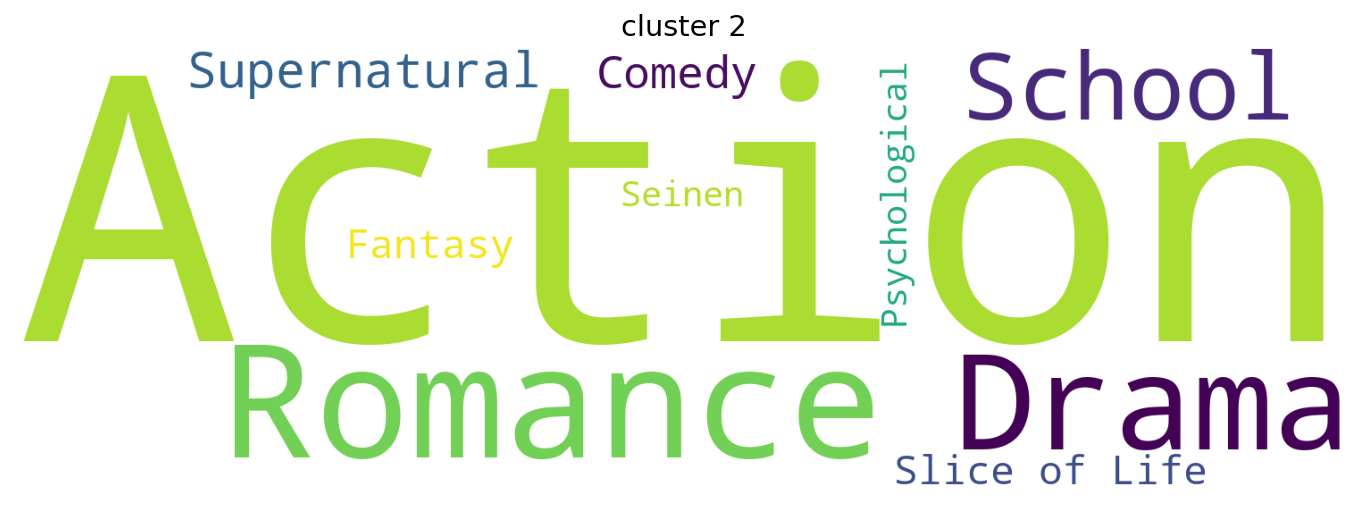

In [ ]:
c2_animelist = list(c2.sort_values(ascending=False)[0:15].index)
c2_data = pd.DataFrame()
c2_data['genre'],c2_data['episode'],c2_data['rating'],c2_data['member'] =  createAnimeInfoList(c2_animelist)
c2_data.iloc[:,1:4] = c2_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c2_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 2","white")

In [ ]:
keyword_occurences[0:5]

[['Action', 7],
 [' Romance', 7],
 [' Drama', 6],
 [' School', 6],
 [' Supernatural', 6]]

In [ ]:
c2_data['episode'].mean()

19.2

In [ ]:
print('cluster 2\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c2_data['episode'].mean(), c2_data['rating'].mean(),c2_data['member'].mean()))

cluster 2
AVG episode : 19.2
AVG movie rating : 7.666666666666667
AVG member : 585425.2


### Cluster 3

In [ ]:
c3.sort_values(ascending=False)[0:15]

name
Death Note                          0.791139
Shingeki no Kyojin                  0.791139
Sword Art Online                    0.683544
Fullmetal Alchemist: Brotherhood    0.620253
Angel Beats!                        0.594937
Mirai Nikki (TV)                    0.582278
Sen to Chihiro no Kamikakushi       0.563291
Ao no Exorcist                      0.563291
Another                             0.556962
Steins;Gate                         0.544304
Code Geass: Hangyaku no Lelouch     0.531646
Elfen Lied                          0.531646
Soul Eater                          0.518987
Durarara!!                          0.512658
Tokyo Ghoul                         0.506329
dtype: float64

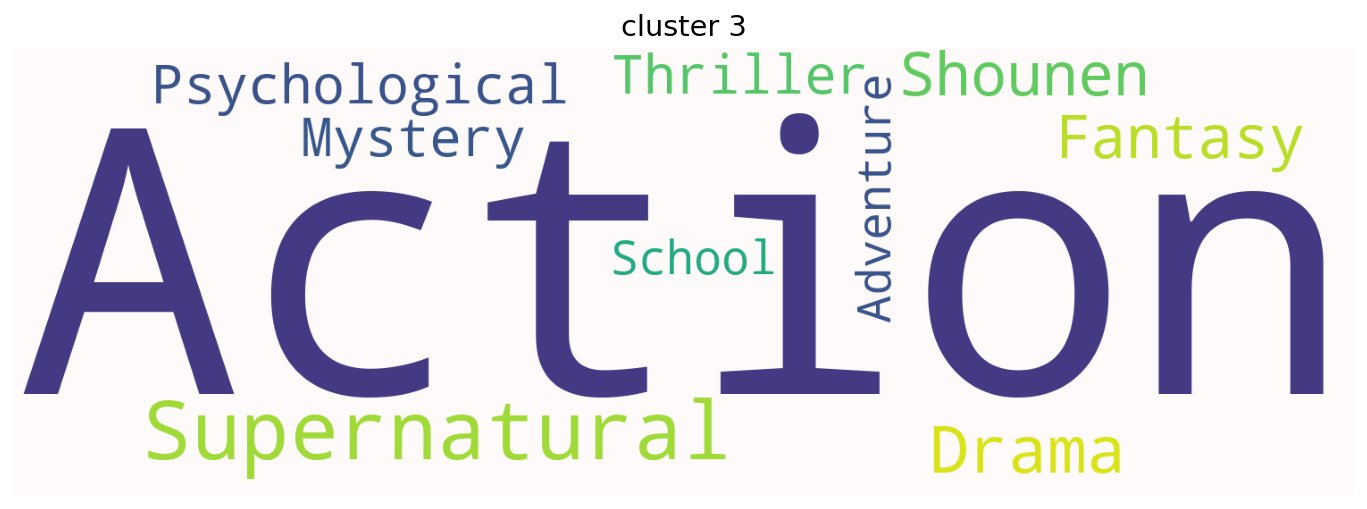

In [ ]:
c3_animelist = list(c3.sort_values(ascending=False)[0:15].index)
c3_data = pd.DataFrame()
c3_data['genre'],c3_data['episode'],c3_data['rating'],c3_data['member'] =  createAnimeInfoList(c3_animelist)
c3_data.iloc[:,1:4] = c3_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c3_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 3","snow")

In [ ]:
keyword_occurences[0:5]

[['Action', 11],
 [' Supernatural', 10],
 [' Drama', 6],
 [' Shounen', 5],
 [' Fantasy', 5]]

In [ ]:
print('cluster 3\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c3_data['episode'].mean(), c3_data['rating'].mean(),c3_data['member'].mean()))

cluster 3
AVG episode : 25.133333333333333
AVG movie rating : 7.866666666666666
AVG member : 688235.7333333333


* По средним оцен и характеристикам кластеров, пользователям больше нравится совмещение драмы-триллера-фантастики, объедененные темой приключений и мистики, в последнем кластере именно такое сочетание набирает более высокий рейтинг, и снимают более длинное по эпизодам аниме.


---




* В то время как романтика и комедия представлены в кластерах в более низким средним рейтингом
Интересно, что в первом кластере определились жанры аниме связанные с эротикой, они тоже имеют более низкий рейтинг
